<a href="https://www.kaggle.com/code/m000sey/ps-3-25-eda-new-features-and-lgbm-hgb?scriptVersionId=153442044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
### Import libraries
import pandas as pd
import numpy as np
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import catboost, xgboost, lightgbm
from scipy.stats import yeojohnson
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, RepeatedKFold, train_test_split, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_auc_score, roc_curve
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import HuberRegressor
from sklearn.compose import TransformedTargetRegressor
import sklearn.cluster as skc 
from sklearn.cluster import KMeans
import time, optuna, warnings, os, platform, time, random, gc, itertools, re
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
!pip install kneed
from kneed import KneeLocator
from tqdm import tqdm
print("Libraries imported...")

  Obtaining dependency information for kneed from https://files.pythonhosted.org/packages/9a/1b/7e726d8616e813007874468c61790099ba21493e0ea07561b7d9fc53151c/kneed-0.8.5-py3-none-any.whl.metadata
Libraries imported...


In [2]:
# Define some values
SEED = 42
FOLDS = 10
ROUNDS = 100

# Import the data
if platform.system()   == "Windows":
    train_path          = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/train.csv'
    test_path           = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/test.csv'
    sample_path         = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/sample_submission.csv'
    original_1_path     = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/original_1.csv'
    original_2_path     = 'C:/Users/COMMANDCENTER/Desktop/coding/playground_series/hardness/original_2.csv'
    print("Using Windows file path...")
elif platform.system() == "Darwin":
    train_path          = '/Users/shane/Documents/data_science/train.csv'
    test_path           = '/Users/shane/Documents/data_science/test.csv'
    print("Using Mac file path...")
elif platform.system() == "Linux":
    train_path          = '/kaggle/input/playground-series-s3e25/train.csv'
    test_path           = '/kaggle/input/playground-series-s3e25/test.csv'
    sample_path         = '/kaggle/input/playground-series-s3e25/sample_submission.csv'
    original_1_path     = '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv'
    original_2_path     = '/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv'
    print("Using Linux file path...")
else:
    raise OSError("Unsupported operating system")
    
train = pd.read_csv(train_path, index_col='id')
test = pd.read_csv(test_path, index_col='id')
sample = pd.read_csv(sample_path)
original_1 = pd.read_csv(original_1_path)
original_2 = pd.read_csv(original_2_path)
print("Data loaded...")

Using Linux file path...
Data loaded...


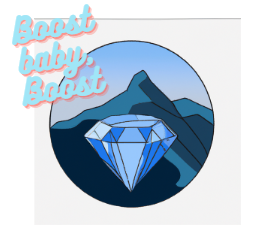

**Understanding the shake up:**
- Most playground series competitions have a pretty serious shake up. This is because of a couple of reasons, but mostly folks trust the public leaderboard more than their robust cross val techniques. Another reason is limited synthetic data to work with.
- We've seen a couple of different strategies in this competition yield fantastic public leaderboard scores like feeding LGBM predictions into a neural network and treating the task at hand as a multi-class classification problem.
- I am going to stay true to my modest modelling techniques to try to weather the impending shake up, and I suggest you do the same. 

**Understanding the question:**
- We are trying to predict Hardness based on compound attributes.
    - What is Hardness? --> A minerals resistance to being scratched.
    - What do scientists know about what affects hardness? --> The strength of bonds and structure of the lattice
    - What sorts of compound attributes affect hardness the most? --> element identity, atom density, impurities, and crystal structure. Seems like bond strength is the most important.
    
**Example:** The chemical formula for both diamond and graphite is simply Carbon, but the way the individual atoms are bonded and arranged makes diamond much 'harder' than graphite.

**Notebook gameplan:**
1. Use KNN to impute chemical structure and chemical formula features from original dataset
2. Create new features with KMeans
3. Conduct univariate and multivariate EDA
4. Create new features according to the imputed chemical formulas
5. Elemental EDA
6. Modelling
7. Submission w/ tuned sample weights

**Important notebooks:** I either used their work directly or their notebooks really helped my thought process
1. https://www.kaggle.com/competitions/playground-series-s3e25/discussion/455888 -- AmbrosM's tuning of sample weights
2. https://www.kaggle.com/code/yantxx/catboost-regressor-mohs-hardness-prediction -- Yan's KNN routine.
3. https://www.kaggle.com/code/oscarm524/ps-s3-ep25-eda-modeling-submission -- Oscar's cross val approaches are always great. Tried using his weight assignment routine, but it didn't work for me.
4. https://www.kaggle.com/code/tonyyunyang99/luck-is-all-you-need -- This post steered me in the right direction and I really love Paddy's Shap plots
5. https://www.kaggle.com/code/iqbalsyahakbar/ps3e25-mohs-hardness-regression-for-beginners -- I appreciated Iqbal's dendrogram.

*As always, I wanted to thank the Kaggle community for helping me learn so much in this competition -- regardless of how I feel about the eval metric.*

In [3]:
# reconfigure some of the original data
original_1 = original_1[(original_1 == 0).sum(axis=1) <= 2]
original_1 = original_1.dropna(subset=['Crystal structure'])
original_1 = original_1.drop(['Unnamed: 0'], axis=1)
original_2 = original_2.drop(['Unnamed: 0'], axis=1)
column_order = [col for col in original_2.columns if col != 'Hardness'] + ['Hardness']
original_2 = original_2[column_order]

# Drop duplicates
duplicates_original_2 = original_2.duplicated().sum()
print("pre-drop  duplicates in original_2:", duplicates_original_2)
original_2 = original_2.drop_duplicates()
duplicates_original_2 = original_2.duplicated().sum()
print("post-drop duplicates in original_2:", duplicates_original_2)

# add the original data to the synthetic
train = pd.concat([original_2, train])
train = train.reset_index(drop=True)

# rename some columns to make human happy
def rename_cols(df):
    df.rename(columns={'allelectrons_Total': 'num_electrons'}, inplace=True)
    df.rename(columns={'density_Total': 'total_density'}, inplace=True)
    df.rename(columns={'allelectrons_Average': 'avg_electrons'}, inplace=True)
    df.rename(columns={'val_e_Average': 'avg_val_e'}, inplace=True)
    df.rename(columns={'atomicweight_Average': 'avg_at_wt'}, inplace=True)
    df.rename(columns={'ionenergy_Average': 'avg_ion_energy'}, inplace=True)
    df.rename(columns={'el_neg_chi_Average': 'avg_electroneg'}, inplace=True)
    df.rename(columns={'R_vdw_element_Average': 'avg_vdw_rad'}, inplace=True)
    df.rename(columns={'R_cov_element_Average': 'avg_cov_rad'}, inplace=True)
    df.rename(columns={'zaratio_Average': 'avg_PtoN'}, inplace=True)
    df.rename(columns={'density_Average': 'avg_density'}, inplace=True)
    return df

train = rename_cols(train)
test = rename_cols(test)
original_1 = rename_cols(original_1)

print("Data reconfigured...")

pre-drop  duplicates in original_2: 23
post-drop duplicates in original_2: 0
Data reconfigured...


# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">KNN imputation</span>
- I used this code to make two new features: crystal structure and chemical formula

In [4]:
# K-NN from Yan and adjusted to add a formula feature
    # https://www.kaggle.com/code/yantxx/catboost-regressor-mohs-hardness-prediction/notebook
    
common_columns_df = [col for col in train.columns if col in original_1.columns]
X_original = original_1[common_columns_df]
X_train = train[common_columns_df]

KNN = NearestNeighbors(n_neighbors=1, p=2) # p=2 means we're using the euclidean distance
KNN.fit(X_original)
distances_df, indices_df = KNN.kneighbors(X_train)
train['crystal_strx'] = original_1.iloc[indices_df.flatten()]['Crystal structure'].values
train['imputed_formula'] = original_1.iloc[indices_df.flatten()]['Formula'].values

common_columns_test = [col for col in test.columns if col in original_1.columns]
X_test = test[common_columns_test]

distances_test, indices_test = KNN.kneighbors(X_test)
test['crystal_strx'] = original_1.iloc[indices_test.flatten()]['Crystal structure'].values
test['imputed_formula'] = original_1.iloc[indices_test.flatten()]['Formula'].values

print("KNN features created...")

# Encode categorical features
label_encoder = LabelEncoder()
train['crystal_strx_encoded'] = label_encoder.fit_transform(train['crystal_strx'])
test['crystal_strx_encoded']  = label_encoder.transform(test['crystal_strx'])

# Map each unique 'imputed_formula' to a number before KMeans
unique_formulas = train['imputed_formula'].unique()
formula_to_number_mapping = {formula: number for number, formula in enumerate(unique_formulas)}
train['formula_number'] = train['imputed_formula'].map(formula_to_number_mapping)
test['formula_number'] = test['imputed_formula'].map(formula_to_number_mapping)

# Drop the original 'Crystal structure' columns
train = train.drop(['crystal_strx', 'imputed_formula'], axis=1)
test = test.drop(['crystal_strx', 'imputed_formula'], axis=1)

column_order = [col for col in train.columns if col != 'Hardness'] + ['Hardness']
train = train[column_order]

X = train.iloc[:, :-1]
y = train.iloc[:, -1]
z = test

KNN features created...


# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">KMeans to make a cluster feature</span>
This is the code I use to judge how many clusters to use, but it takes a while to run. I have another bit of code I use to just create the features fast knowing how many clusters I want to use.

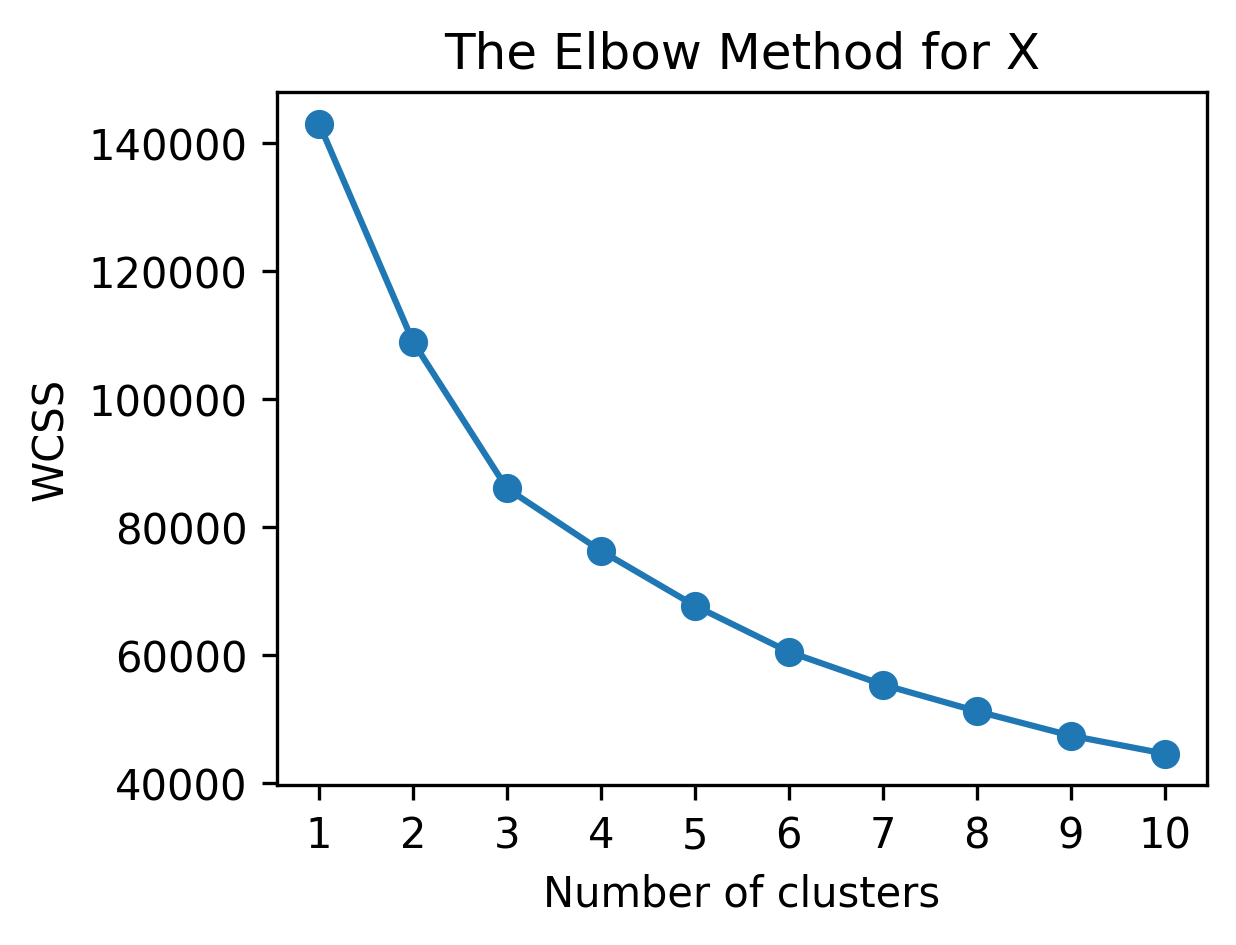

K-value from computer for X: 3
Cluster counts for X:
Cluster 1: 8458
Cluster 2: 2467
Cluster 3: 81


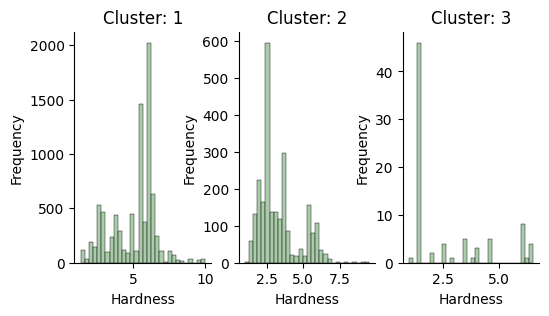

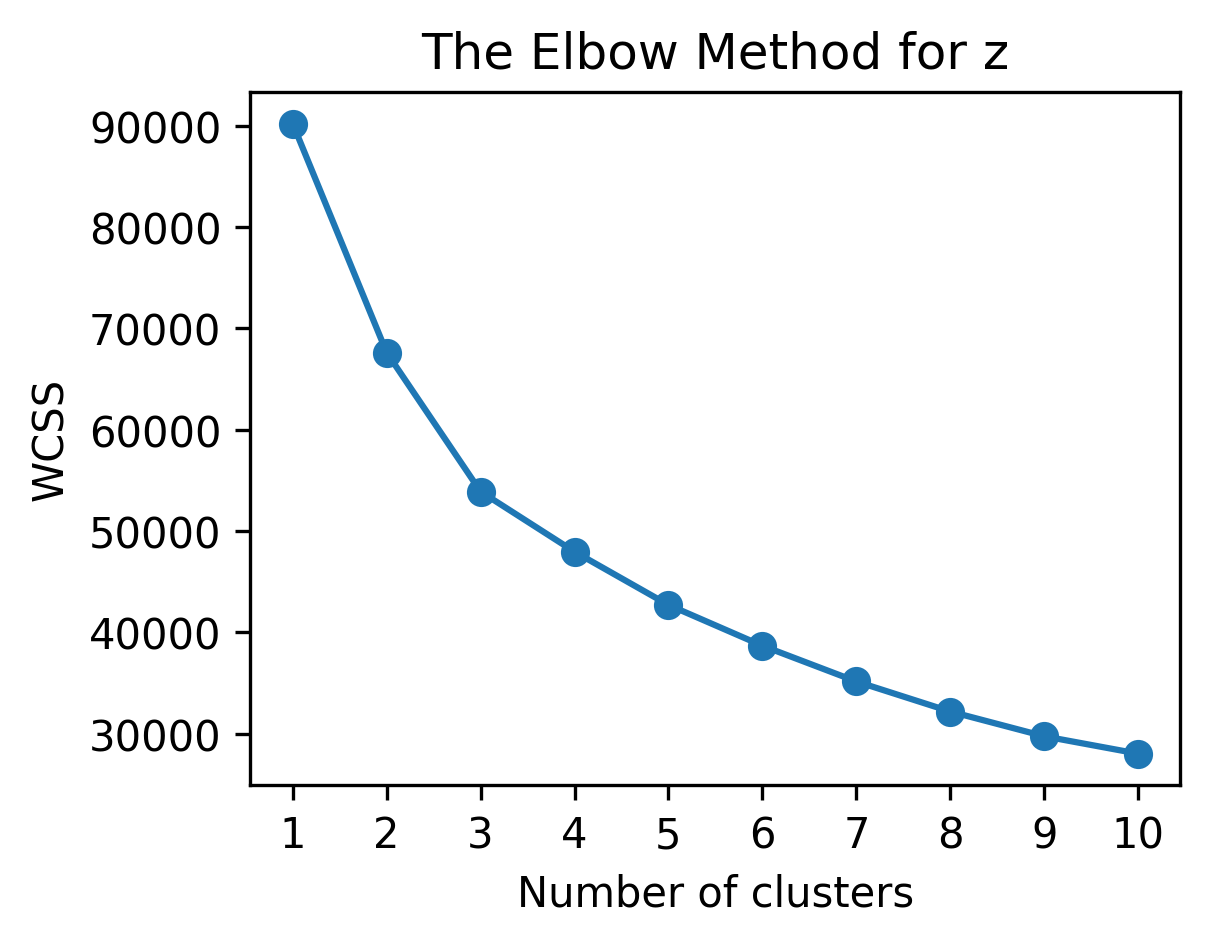

K-value from computer for z: 3
Cluster counts for z:
Cluster 1: 5351
Cluster 2: 1542
Cluster 3: 46


In [5]:
def K_means_calcs(data, data_name):
    # Scale for KMeans
    scaled_data = StandardScaler().fit_transform(data)
    
    # Use human to find elbow point
    wcss = []
    k_range = range(1, 11)
    for i in k_range:
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=SEED, n_init=50)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
    plt.plot(k_range, wcss, marker='o')
    plt.xticks(k_range)
    plt.title(f'The Elbow Method for {data_name}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Use computer to find the elbow point
    kl = KneeLocator(k_range, wcss, curve="convex", direction="decreasing")
    print(f"K-value from computer for {data_name}: {kl.elbow}")

    # Clustering K Means, K=3
    kmeans_3 = KMeans(n_clusters=3, random_state=SEED, n_init=50)
    kmeans_3.fit(scaled_data)
    data['cluster_id'] = kmeans_3.labels_
        
    # Remap cluster labels based on counts
    count_mapping = {cluster: rank + 1 for rank, (cluster, count) in enumerate(data['cluster_id'].value_counts().items())}
    data['cluster_id'] = data['cluster_id'].map(count_mapping)
    
    # Display the counts
    cluster_counts = data['cluster_id'].value_counts()
    print(f"Cluster counts for {data_name}:")
    for cluster, count in cluster_counts.items():
        print(f'Cluster {cluster}: {count}')
    
    if data.equals(X):
        # Plot histograms of Hardness depending on cluster
        X_plus_y = pd.concat([X, y], axis=1)
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 3), sharey=False)
        for cluster, ax in zip(range(1, 4), axes): 
            sns.histplot(X_plus_y[X_plus_y['cluster_id'] == cluster]['Hardness'], 
                         bins=30, kde=False, color='darkseagreen', ax=ax)
            sns.despine(top=True, right=True)
            ax.set_title(f'Cluster: {cluster}')
            ax.set_xlabel('Hardness')
            ax.set_ylabel('Frequency')

K_means_calcs(X, "X")
K_means_calcs(z, "z")

def K_means_nograph(data):
    # Scale for KMeans
    scaled_data = StandardScaler().fit_transform(data)

    # Clustering K Means, K=3
    kmeans_3 = KMeans(n_clusters=3, random_state=SEED, n_init=50)
    kmeans_3.fit(scaled_data)
    data['cluster_id'] = kmeans_3.labels_
        
    # Remap cluster labels based on counts
    count_mapping = {cluster: rank + 1 for rank, (cluster, count) in enumerate(data['cluster_id'].value_counts().items())}
    data['cluster_id'] = data['cluster_id'].map(count_mapping)
    
# K_means_nograph(X)
# K_means_nograph(z)

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Univariate analysis</span>

Train data
Train Unique Hardness Values: [1.0, 1.3, 1.5, 1.8, 2.0, 2.1, 2.2, 2.3, 2.5, 2.6, 2.8, 2.9, 3.0, 3.2, 3.3, 3.5, 3.6, 3.8, 4.0, 4.1, 4.3, 4.5, 4.7, 4.8, 5.0, 5.3, 5.4, 5.5, 5.75, 5.8, 6.0, 6.2, 6.3, 6.4, 6.5, 6.64, 6.7, 6.8, 7.0, 7.3, 7.5, 7.8, 8.0, 8.1, 8.3, 8.5, 9.0, 9.5, 9.8, 10.0]
Number of Train Unique Hardness Values: 50


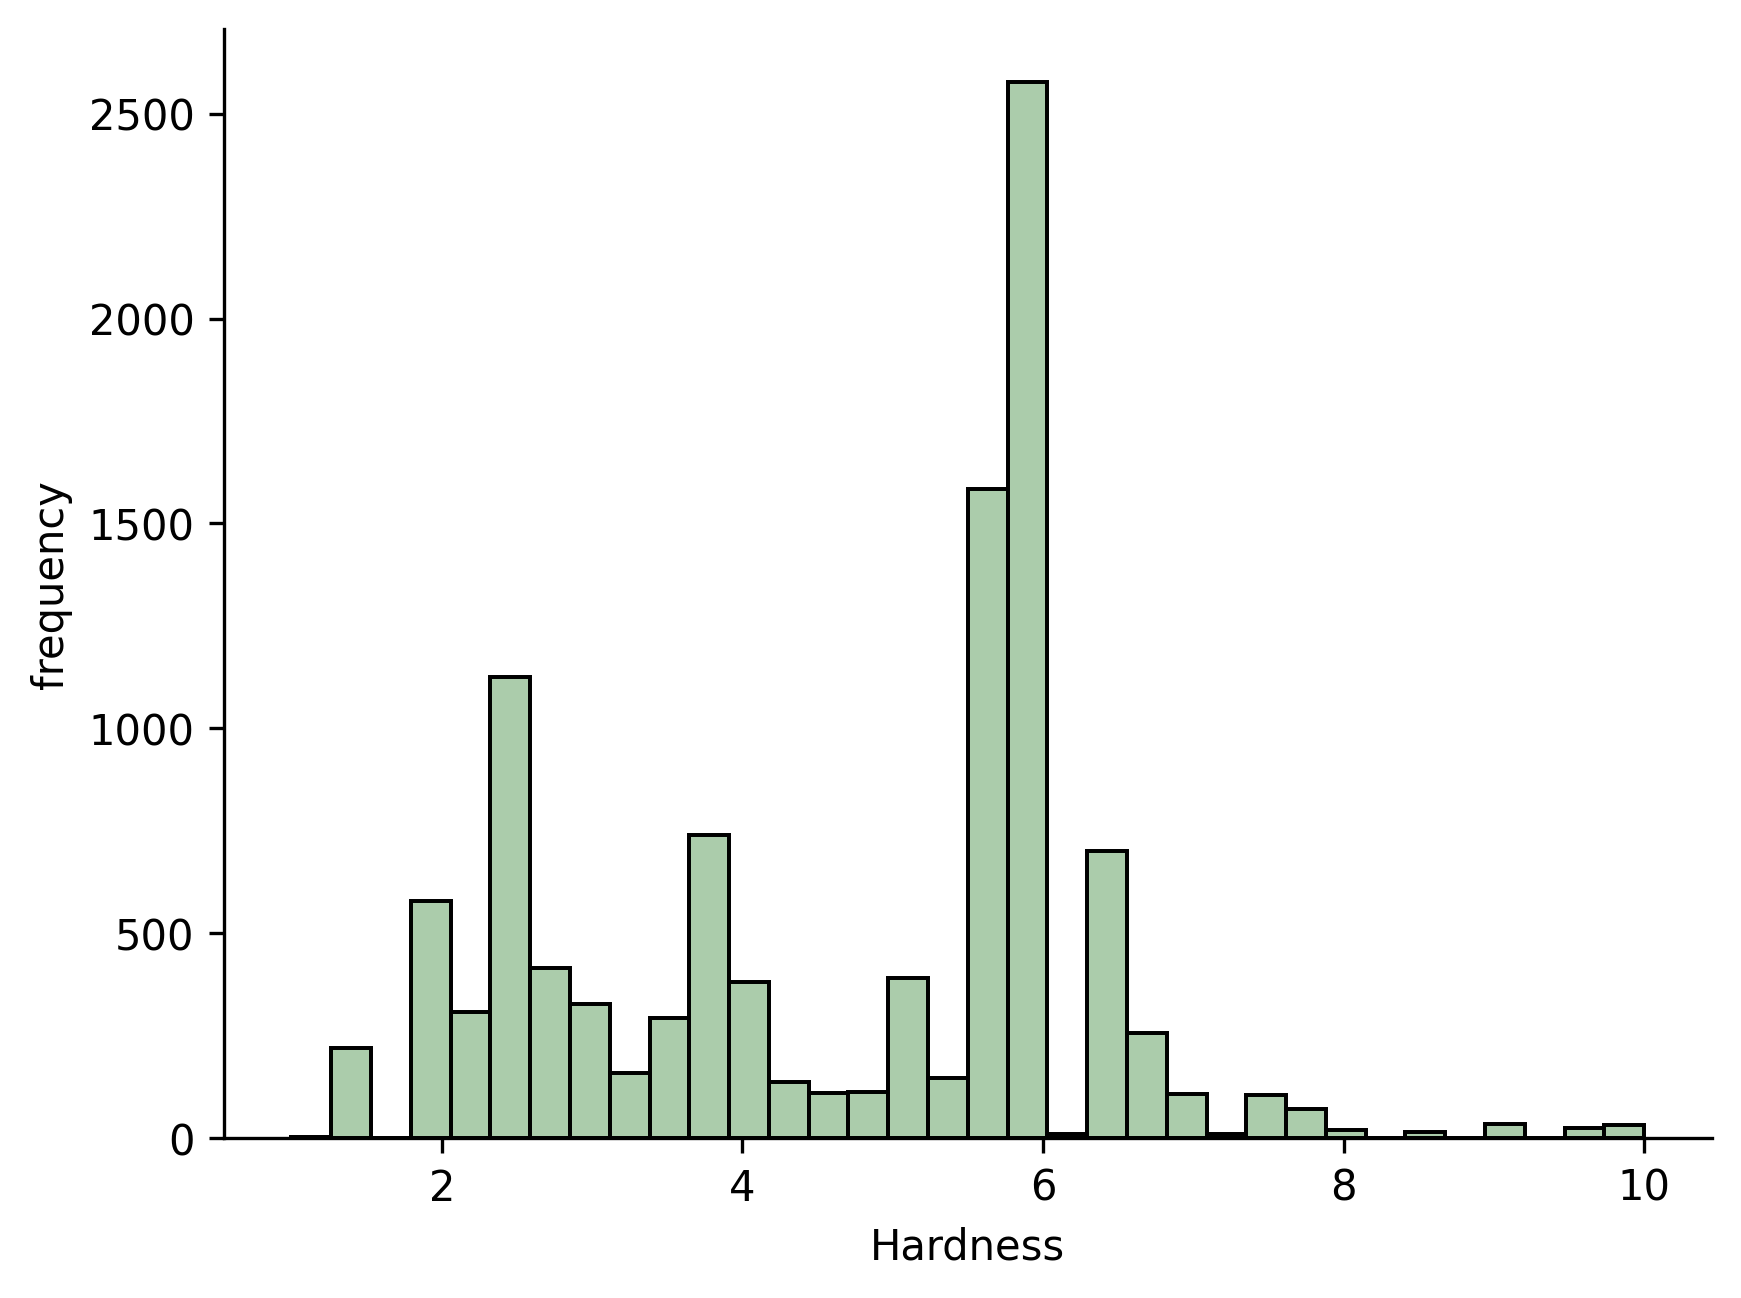

In [6]:
# Target analysis
print("Train data")
unique_hardness_values = sorted(set(y))
print("Train Unique Hardness Values:", unique_hardness_values)
num_unique_hardness_values = len(unique_hardness_values)
print("Number of Train Unique Hardness Values:", num_unique_hardness_values)

# Target distribution (train)
plt.figure(dpi=300)
sns.histplot(y, color='darkseagreen', edgecolor='black')
sns.despine(top=True, right=True)
sns.set(style="whitegrid", font='Arial')
plt.xlabel('Hardness')
plt.ylabel('frequency')
plt.show()

In [7]:
# Univariate analysis w/ histograms and boxplots
def plot_histogram_boxplots_for_dataframe(data, n_rows, n_cols):
    sns.set(style="whitegrid", font='Arial')
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 40), dpi=300)

    for i, column in enumerate(data.columns):
        ax_histo = axes[i, 0]

        ax_histo = sns.histplot(data[column], kde=False, color='darkseagreen', ax=ax_histo)  
        ax_histo.set_xlabel(column)
        ax_histo.set_ylabel("Frequency")
        ax_histo.spines['top'].set_visible(False)
        ax_histo.spines['right'].set_visible(False)
        ax_histo.grid(visible=False)
        
        ax_box = axes[i, 1]
        sns.boxplot(data=data, x=column, color='salmon', width=0.5, ax=ax_box) 
        ax_box.set_xlabel(column)
        ax_box.set_ylabel("")
        ax_box.grid(visible=False)

    plt.tight_layout()
    plt.show()

plot_histogram_boxplots_for_dataframe(X, len(X.columns), 2)

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Multivariate analysis</span>

<Figure size 600x300 with 0 Axes>

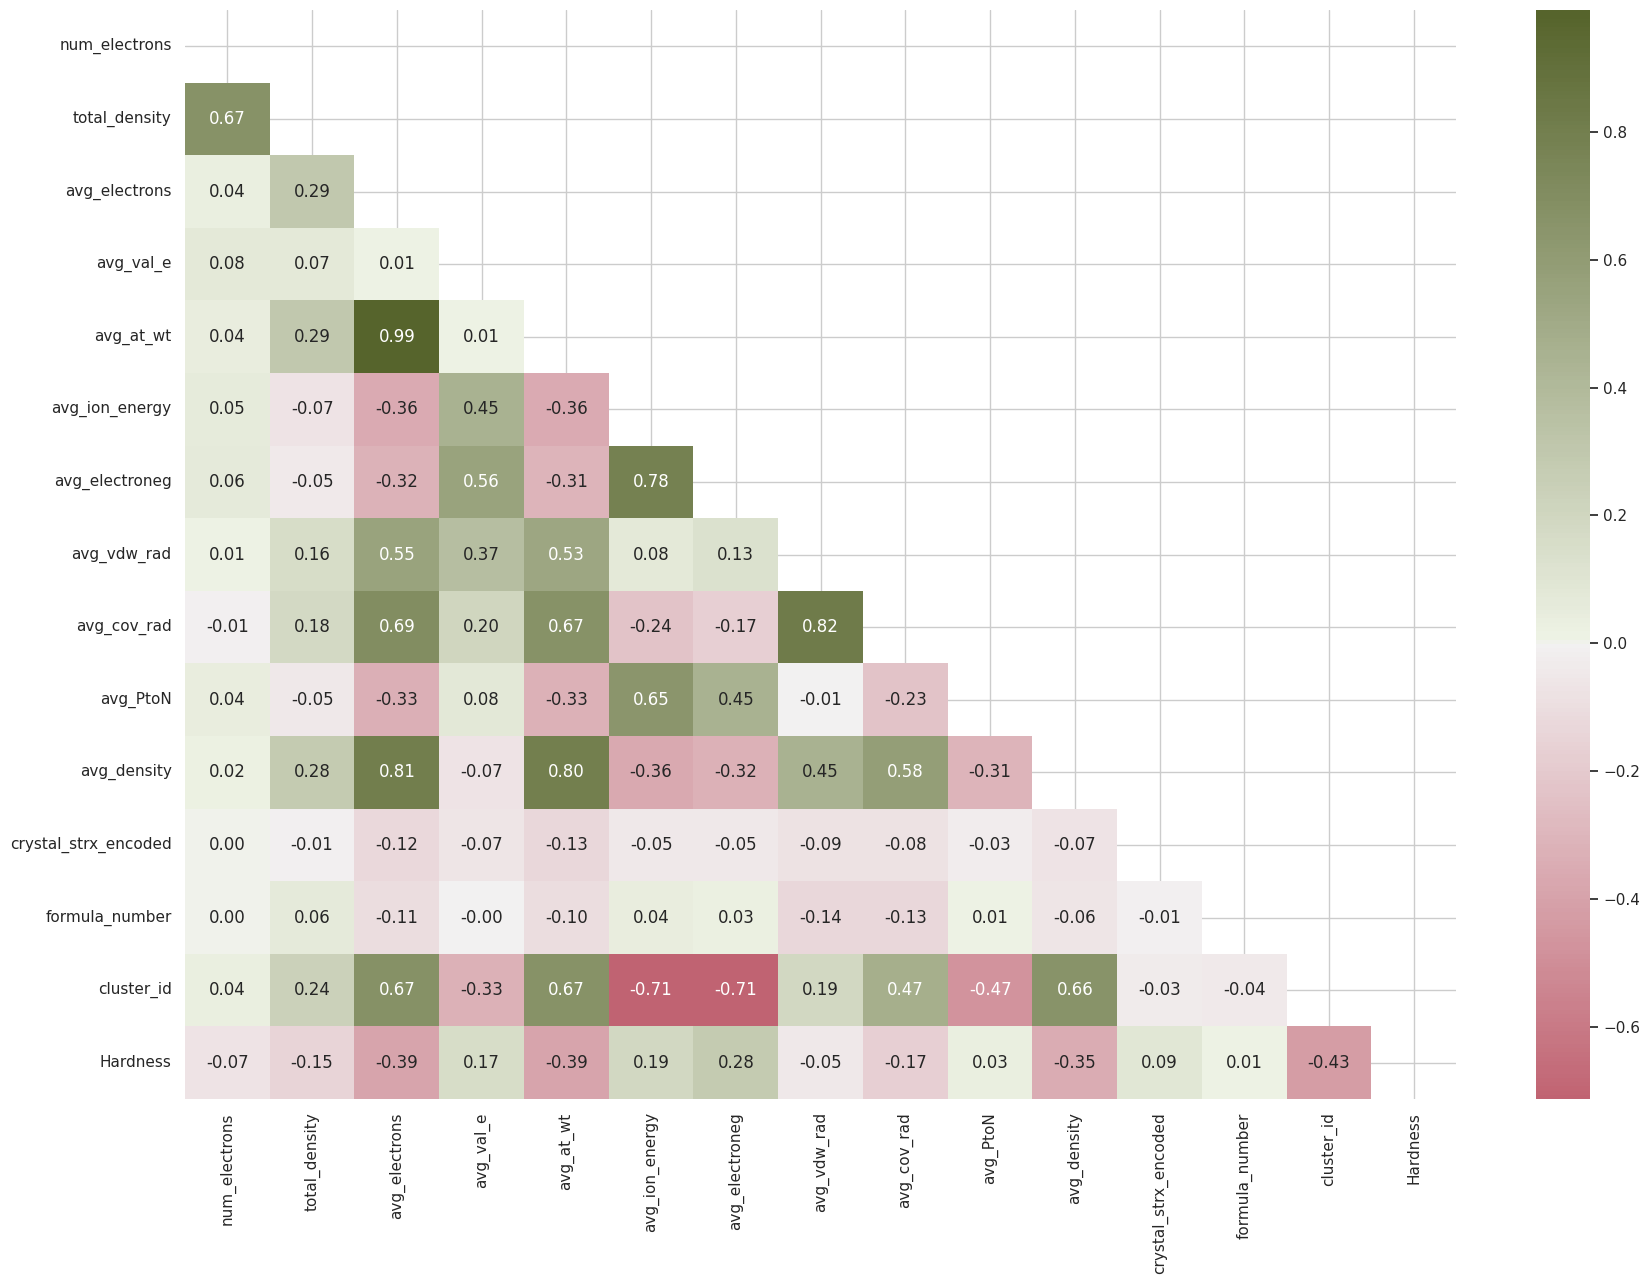

In [8]:
# Correlation matrix
X_plus_y = pd.concat([X, y], axis=1)
plt.figure(figsize=(6, 3))
corr_mat = X_plus_y.corr()
data_mask = np.triu(np.ones_like(corr_mat, dtype = bool)) 
cmap = sns.diverging_palette(7, 100, s = 75, l = 40, n = 20, center = 'light', as_cmap = True)
f, ax = plt.subplots(figsize = (18, 13))
sns.heatmap(corr_mat, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask)
plt.tight_layout()
plt.show()

💡 **insights:** 💡
- num_electrons has to be dropped due to it's correlation profile
- removal betters my CV

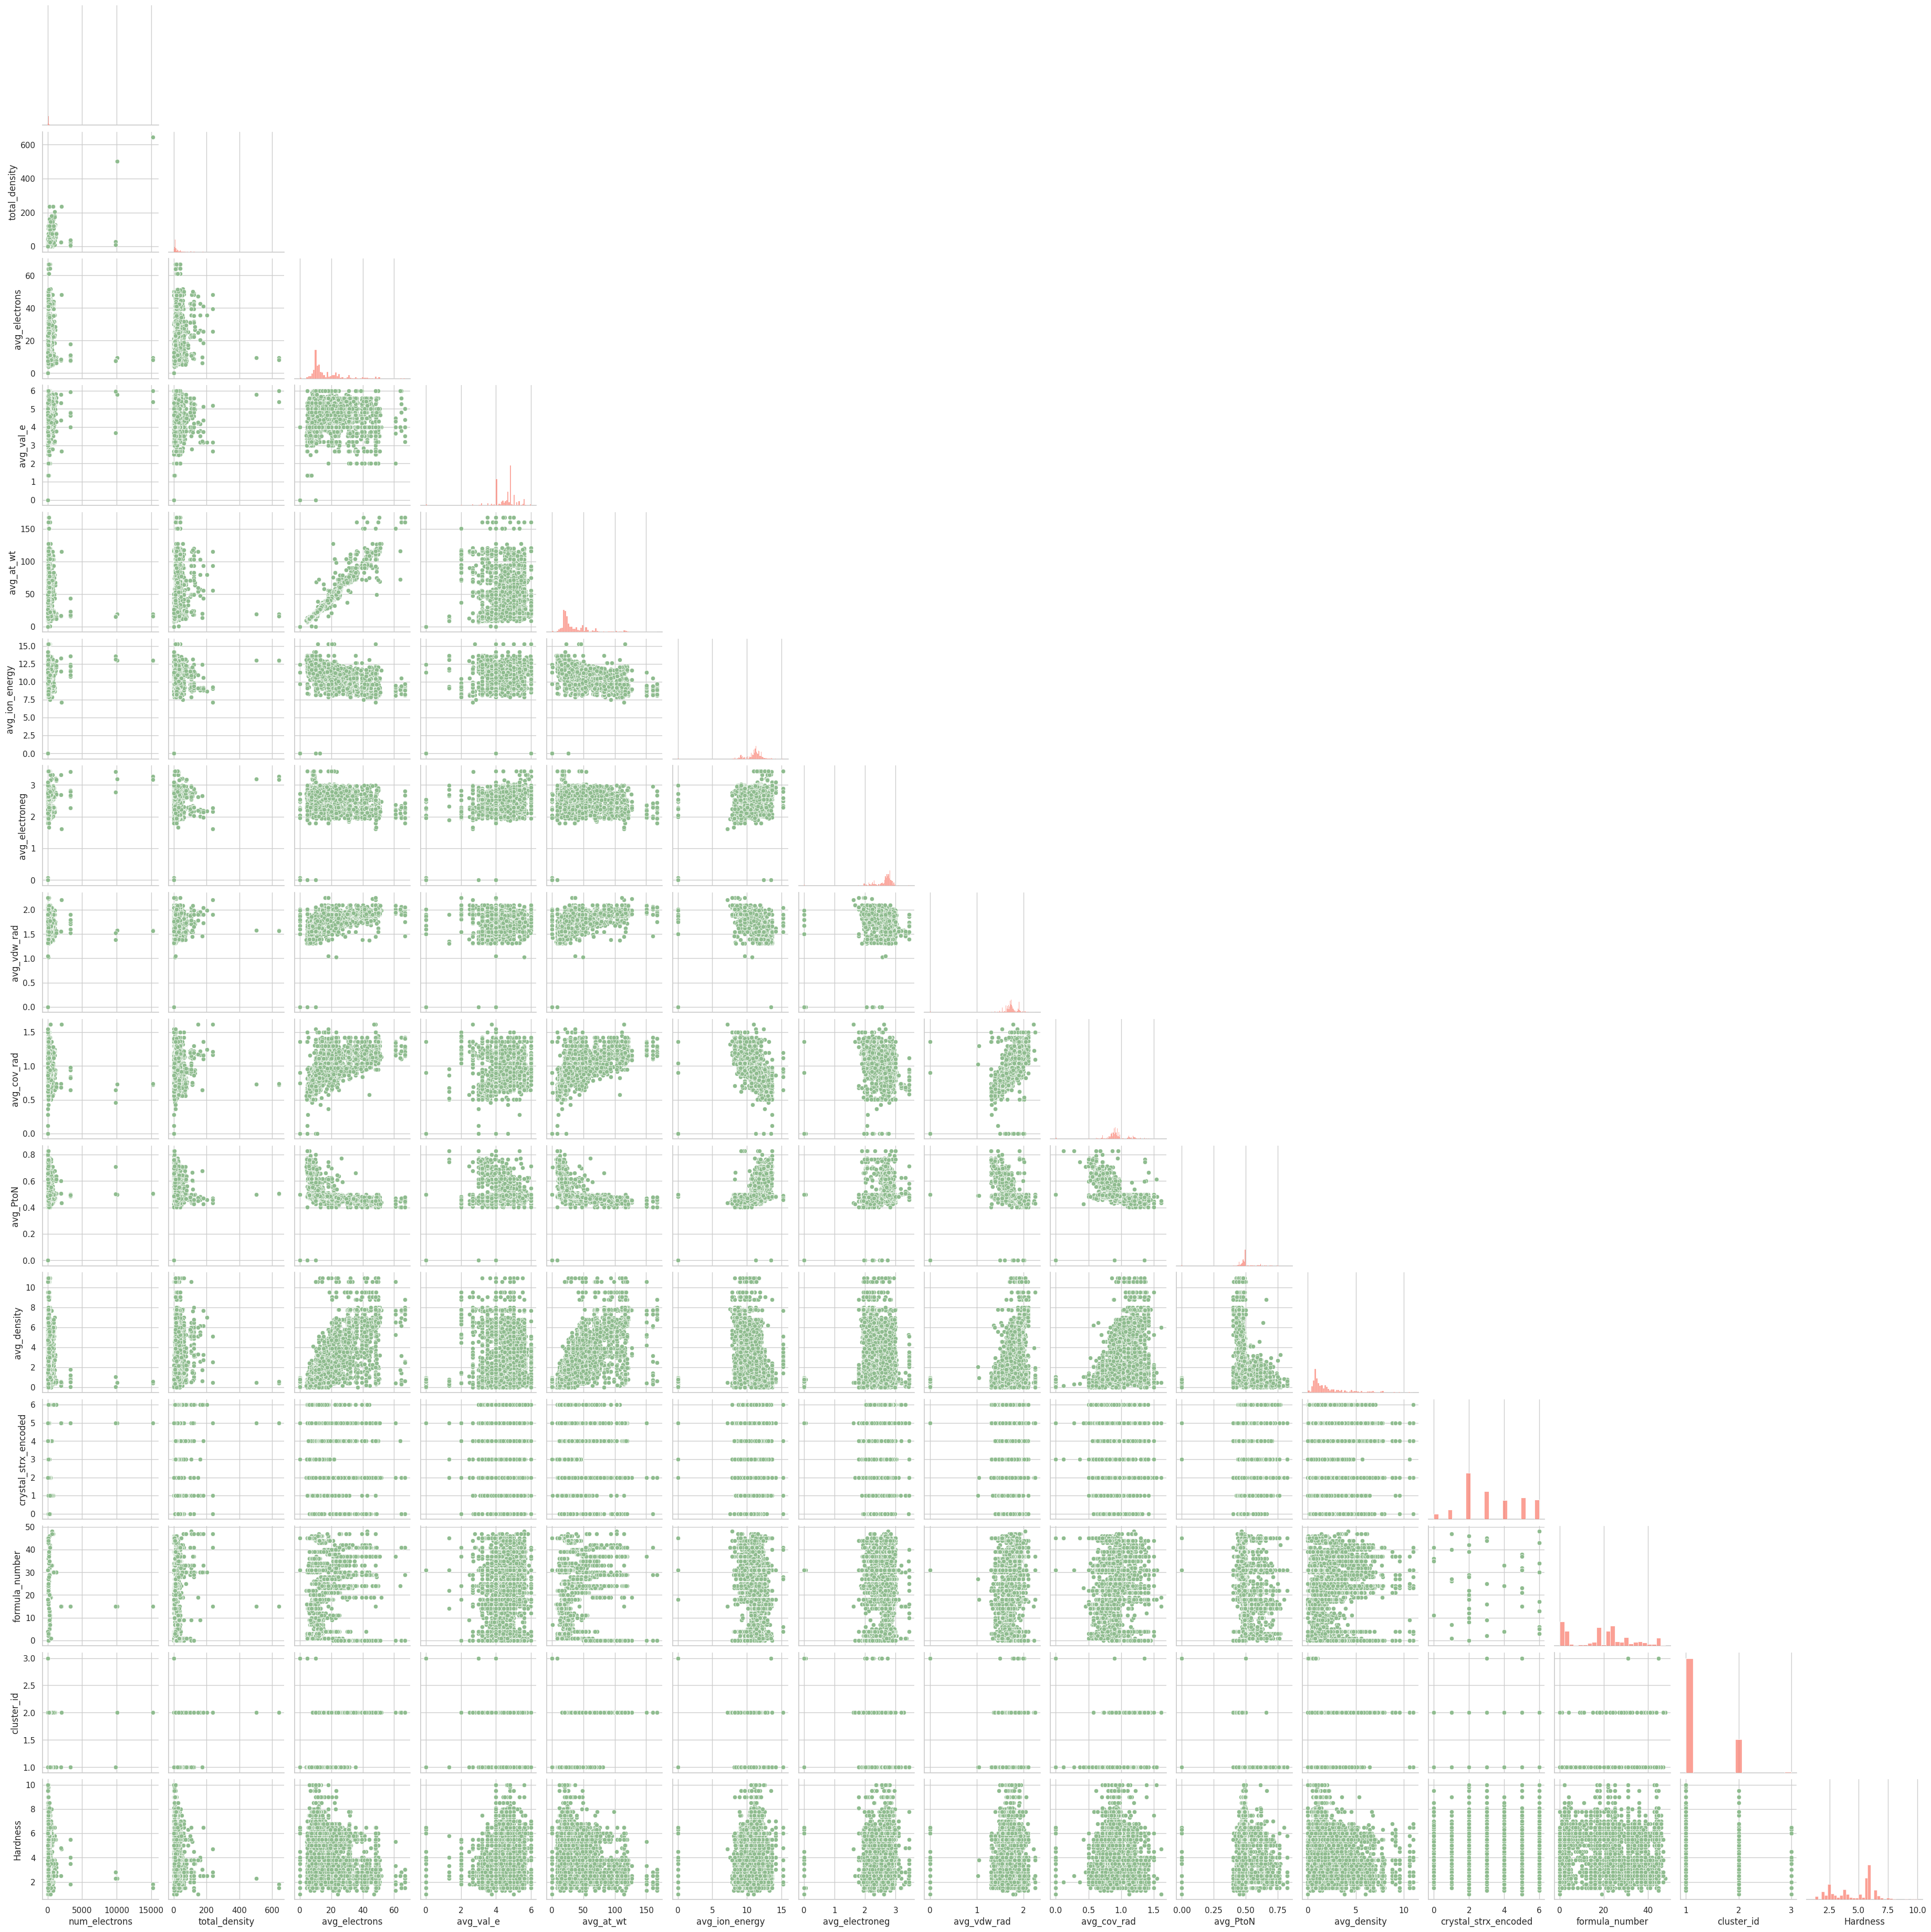

In [9]:
# Pairplot
sns.pairplot(X_plus_y, corner=True, diag_kind="hist", 
                        plot_kws={'color': 'darkseagreen'}, 
                        diag_kws={'color': 'salmon'})
plt.show()

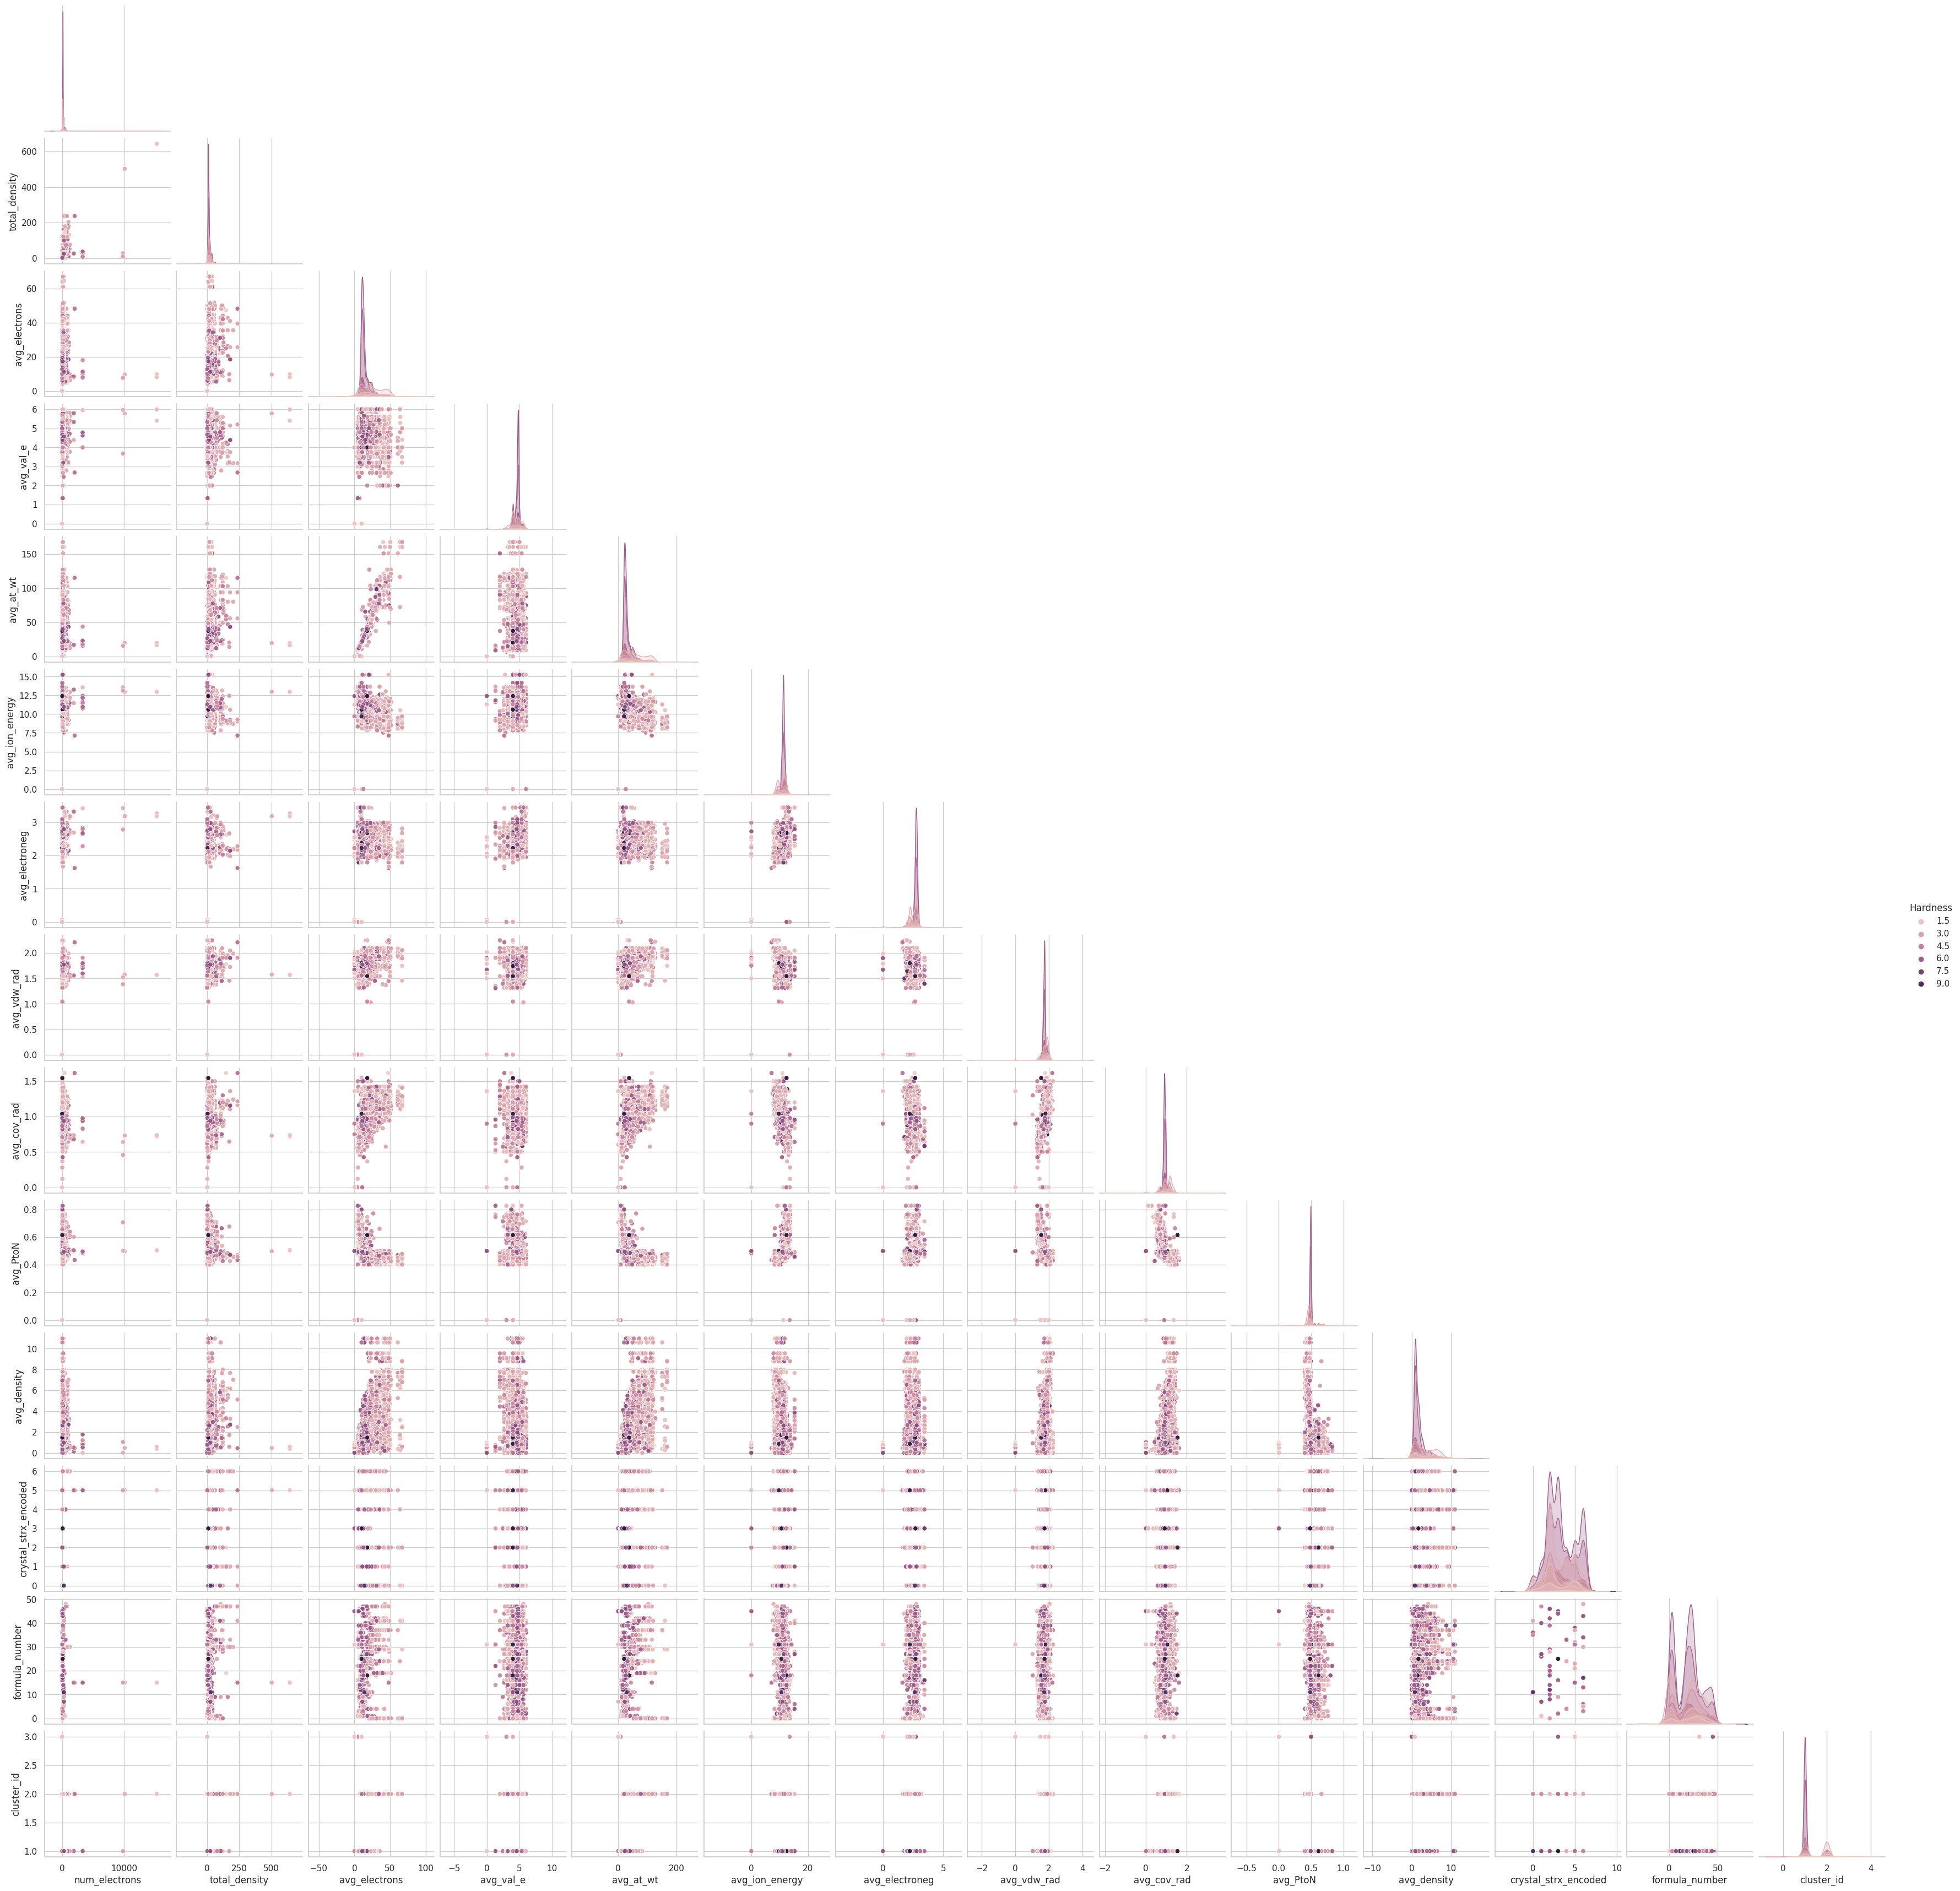

In [10]:
# Pairplot with target
sns.pairplot(X_plus_y, corner=True, diag_kind='kde', hue='Hardness')
plt.show()

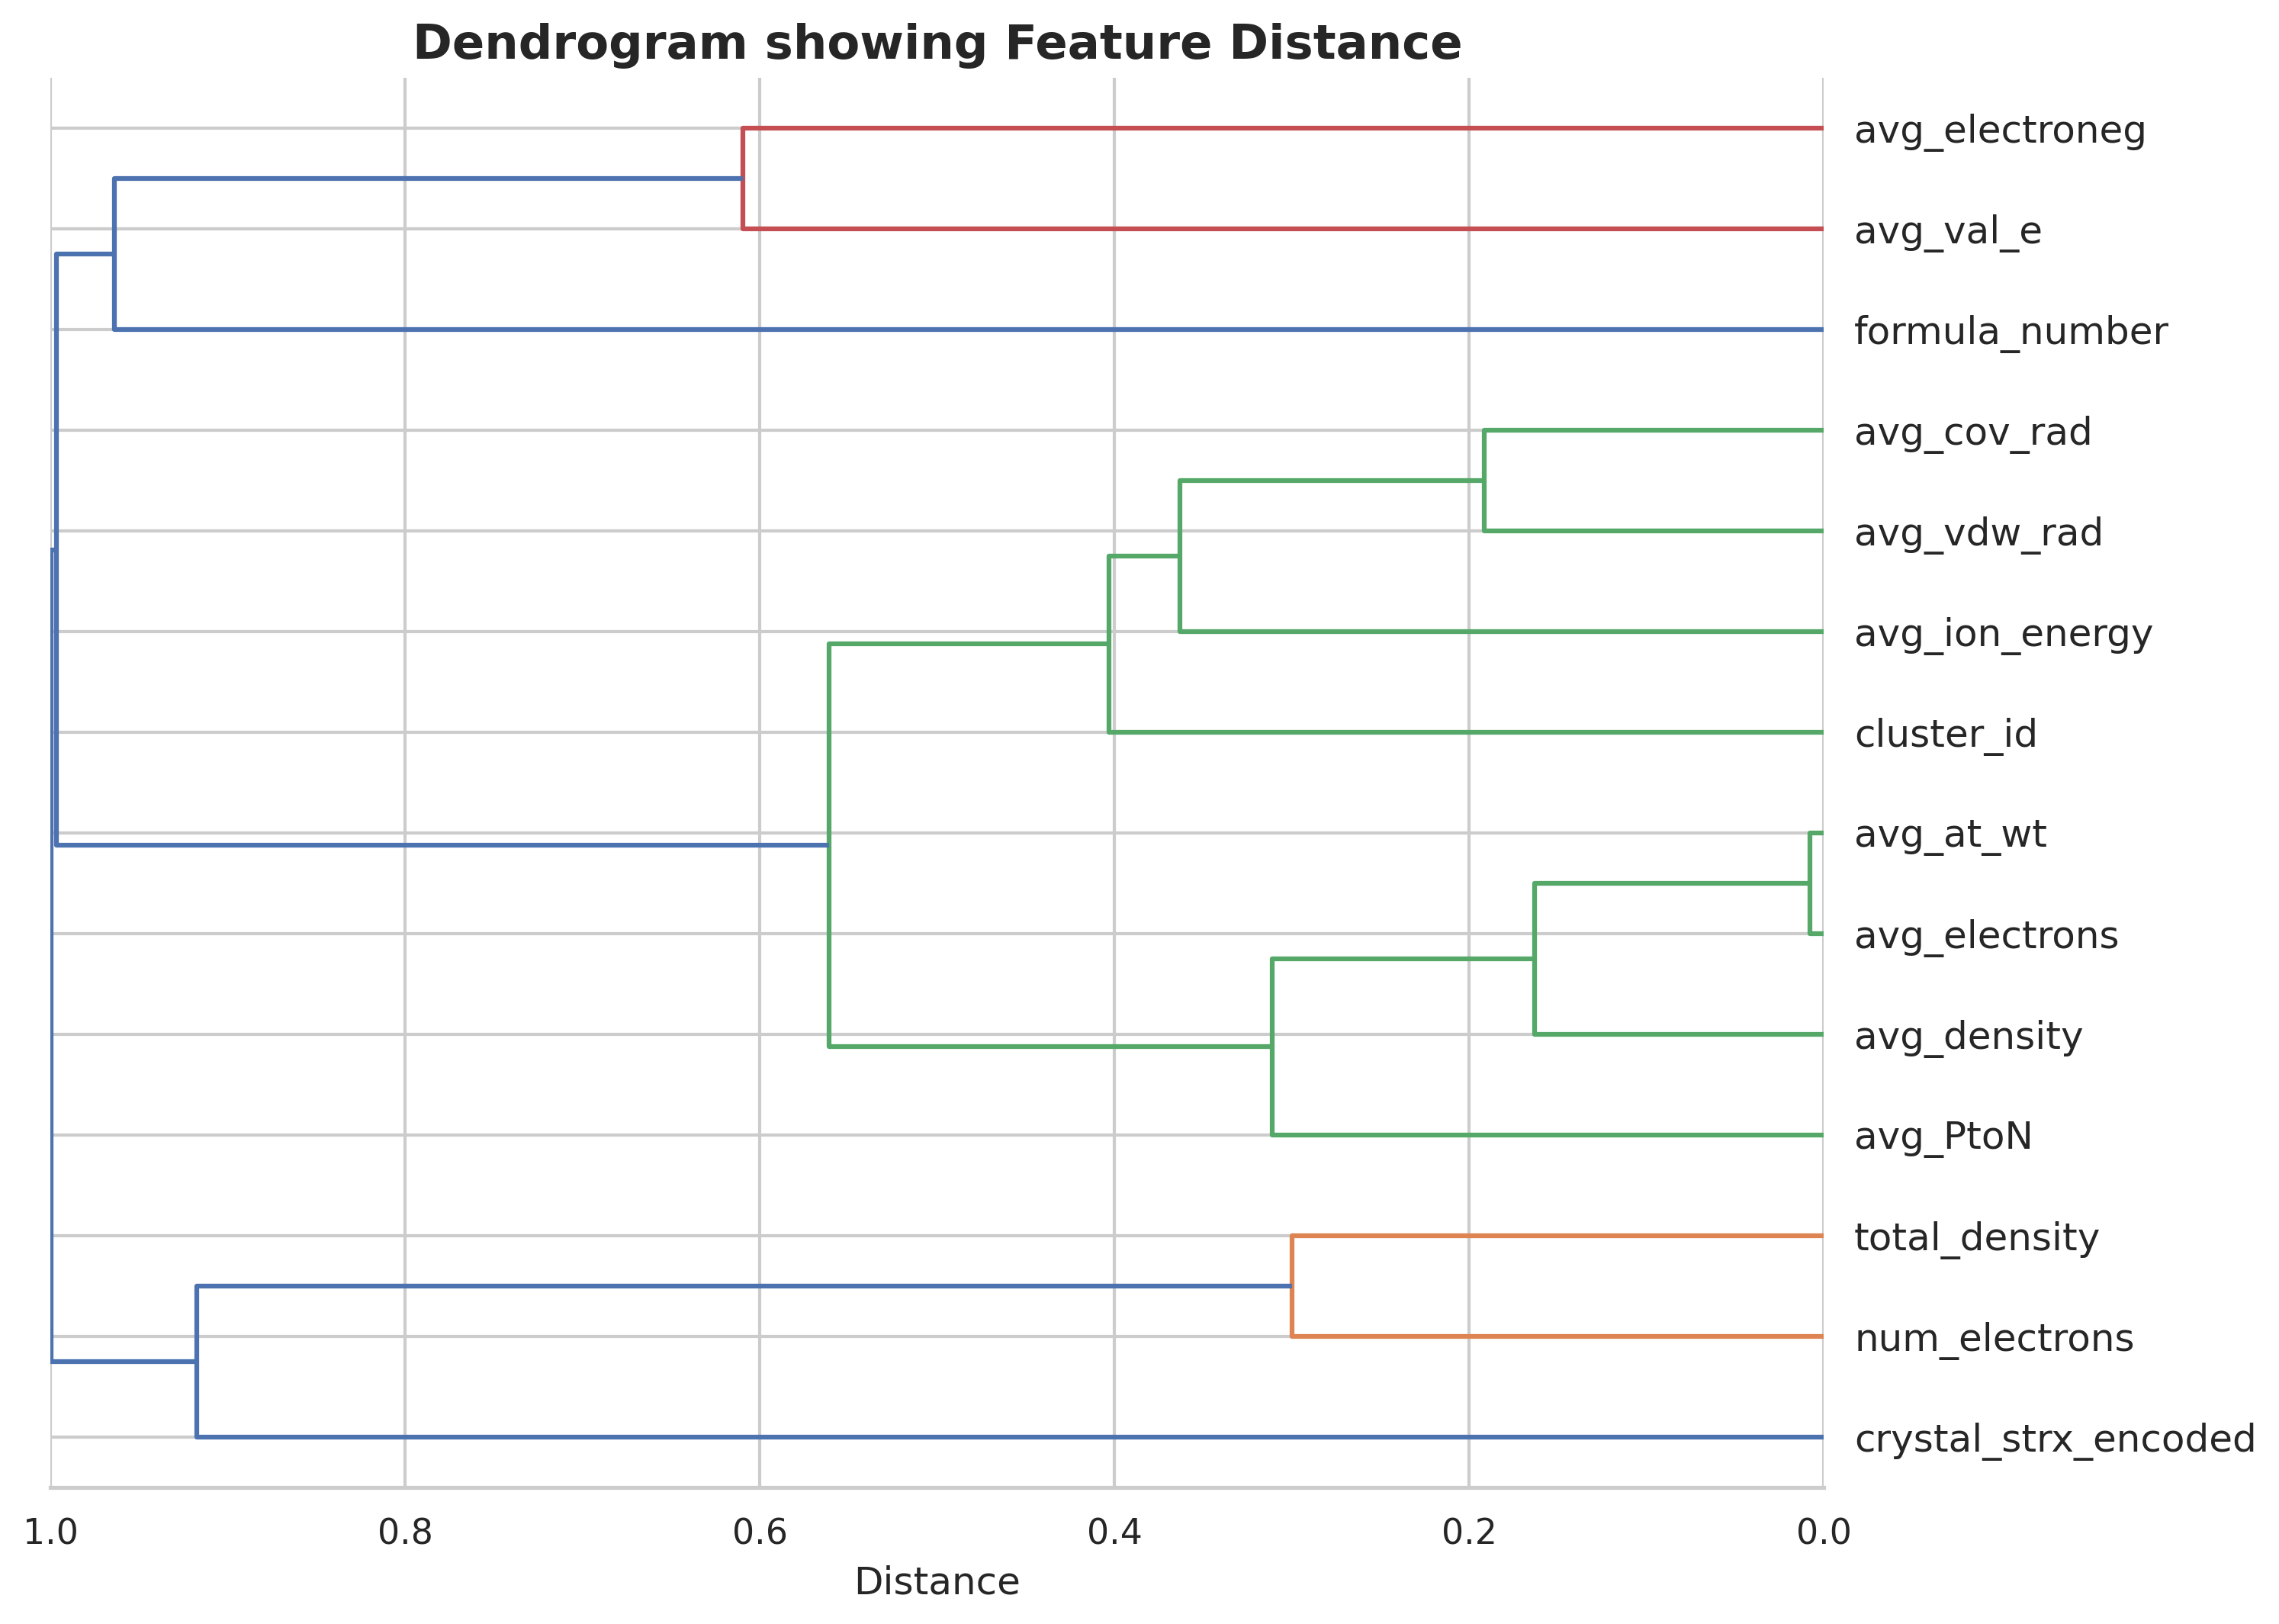

In [11]:
# I used the code for this from this notebook:
    # https://www.kaggle.com/code/iqbalsyahakbar/ps3e25-mohs-hardness-regression-for-beginners

# Dendrogram
corr = X.corr(method='spearman')
dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

plt.figure(figsize=(10, 8), dpi=300)
dendrogram(dist_linkage, labels=X.columns, orientation='left')  # Set orientation to 'left'

plt.title('Dendrogram showing Feature Distance', weight='bold', size=15)
plt.xlabel('Distance')  # Add x-axis label
plt.xlim(1.0, 0)
sns.despine(top=True, right=True, left=True)

plt.show()

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Creating chemical formula features</span>

💡 **insights:** 💡

Creating features with imputed chemical formula:
1. Remapped formula values back to the imputed formula
2. Created a categorical 'doped' feature. Chemical doping is when you introduce impurities to change the chemical structure. I counted anything with a float as being doped, which isn't entirely scientifically accurate because they really just have unorthodox molar ratios. You could consider this feature, "unorthodox ratio".
3. Created a function to break down the formula into a dictionary representing the unique element and it's count, e.g. Oxygen: 10.
4. Created a new feature for every unique element and used the dictionary to map the values
5. Created a new feature of the unique number of elements in the compound
6. Created a new feature of the total number of atoms in the compound

In [12]:
# Decode the 'formula_number' back to original values using the mapping scheme
number_to_formula_mapping = {number: formula for formula, number in formula_to_number_mapping.items()}
X['imputed_formula_decoded'] = X['formula_number'].map(number_to_formula_mapping)
z['imputed_formula_decoded'] = z['formula_number'].map(number_to_formula_mapping)

In [13]:
# Create a new column 'doped' and initialize it with 0
X['doped'], z['doped'] = 0, 0

# Check for the presence of a float in the 'Formula' column and update 'doped' accordingly
X.loc[X['imputed_formula_decoded'].str.contains(r'\.\d+'), 'doped'] = 1
z.loc[z['imputed_formula_decoded'].str.contains(r'\.\d+'), 'doped'] = 1

# Create a new column 'Formula_new' and remove floats from 'Formula'
X['Formula_new'] = X['imputed_formula_decoded'].apply(lambda x: re.sub(r'\d+\.\d+', '', str(x)))
z['Formula_new'] = z['imputed_formula_decoded'].apply(lambda x: re.sub(r'\d+\.\d+', '', str(x)))

# Remove leading or trailing spaces after removing the floats
X['Formula_new'] = X['Formula_new'].str.strip()
z['Formula_new'] = z['Formula_new'].str.strip()

In [14]:
def count_elements(formula):
    # Define a function to extract elements and their counts from a formula
    def extract_elements_and_counts(sub_formula):
        elements_with_counts = re.findall(r'([A-Z][a-z]*)(\d*)', sub_formula)
        return {element: int(count) if count else 1 for element, count in elements_with_counts}

    # Use regular expressions to separate the formula into sub-formulas
    sub_formulas = re.findall(r'([A-Z][a-z]*\d*|\(\w+\)\d*)', formula)

    # Initialize an empty dictionary to store the final result
    result_dict = {}

    # Iterate over each sub-formula and update the result dictionary
    for sub_formula in sub_formulas:
        # Handle nested structures within parentheses
        if '(' in sub_formula:
            element, count = re.match(r'\((\w+)\)(\d*)', sub_formula).groups()
            count = int(count) if count else 1
            nested_result = count_elements(element)
            for nested_element, nested_count in nested_result.items():
                result_dict[nested_element] = result_dict.get(nested_element, 0) + nested_count * count
        else:
            elements_counts = extract_elements_and_counts(sub_formula)
            for element, count in elements_counts.items():
                result_dict[element] = result_dict.get(element, 0) + count

    return result_dict

def element_dictionary_maker(df):
    # Apply the count_elements function to each element in the 'Formula_new' column
    df['element_dict'] = df['Formula_new'].apply(count_elements)
        
    return df

X = element_dictionary_maker(X)
z = element_dictionary_maker(z)

In [15]:
def element_columnizer(df):
    unique_elements = sorted(set().union(*(element_dict.keys() for element_dict in df['element_dict'])))
    
    # Create new columns for each element and set them to zero
    for element in unique_elements:
        df[element] = 0
        
    # Update the values in the new columns based on counts from 'element_dict'
    for index, element_dict in enumerate(df['element_dict']):
        for element, count in element_dict.items():
            df.iloc[index, df.columns.get_loc(element)] += count
    
    return df

X = element_columnizer(X)
z = element_columnizer(z)

In [16]:
def unique_element_counter(df):
    df['unique_element_count'] = df['element_dict'].apply(lambda x: len(x))
    return df

X = unique_element_counter(X)
z = unique_element_counter(z)

In [17]:
def total_element_counter(df):
    # Initialize an empty list to store the total counts
    total_counts = []

    # Iterate over the 'element_counts' column and calculate the total counts
    for element_counts in df['element_dict']:
        total_count = sum(element_counts.values())
        total_counts.append(total_count)

    # Create a new column 'number_of_elements' with the total counts
    df['total_element_count'] = total_counts
    return df

X = total_element_counter(X)
z = total_element_counter(z)

del train, test, test_path, train_path, original_1_path, original_2_path, column_order, distances_test
del common_columns_df, common_columns_test, sample_path, label_encoder, distances_df, duplicates_original_2
del indices_df, indices_test, KNN, X_original, X_test, X_train, original_2, original_1, formula_to_number_mapping
del number_to_formula_mapping, unique_formulas

gc.collect()

448990

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Analyzing chemica formula features</span>

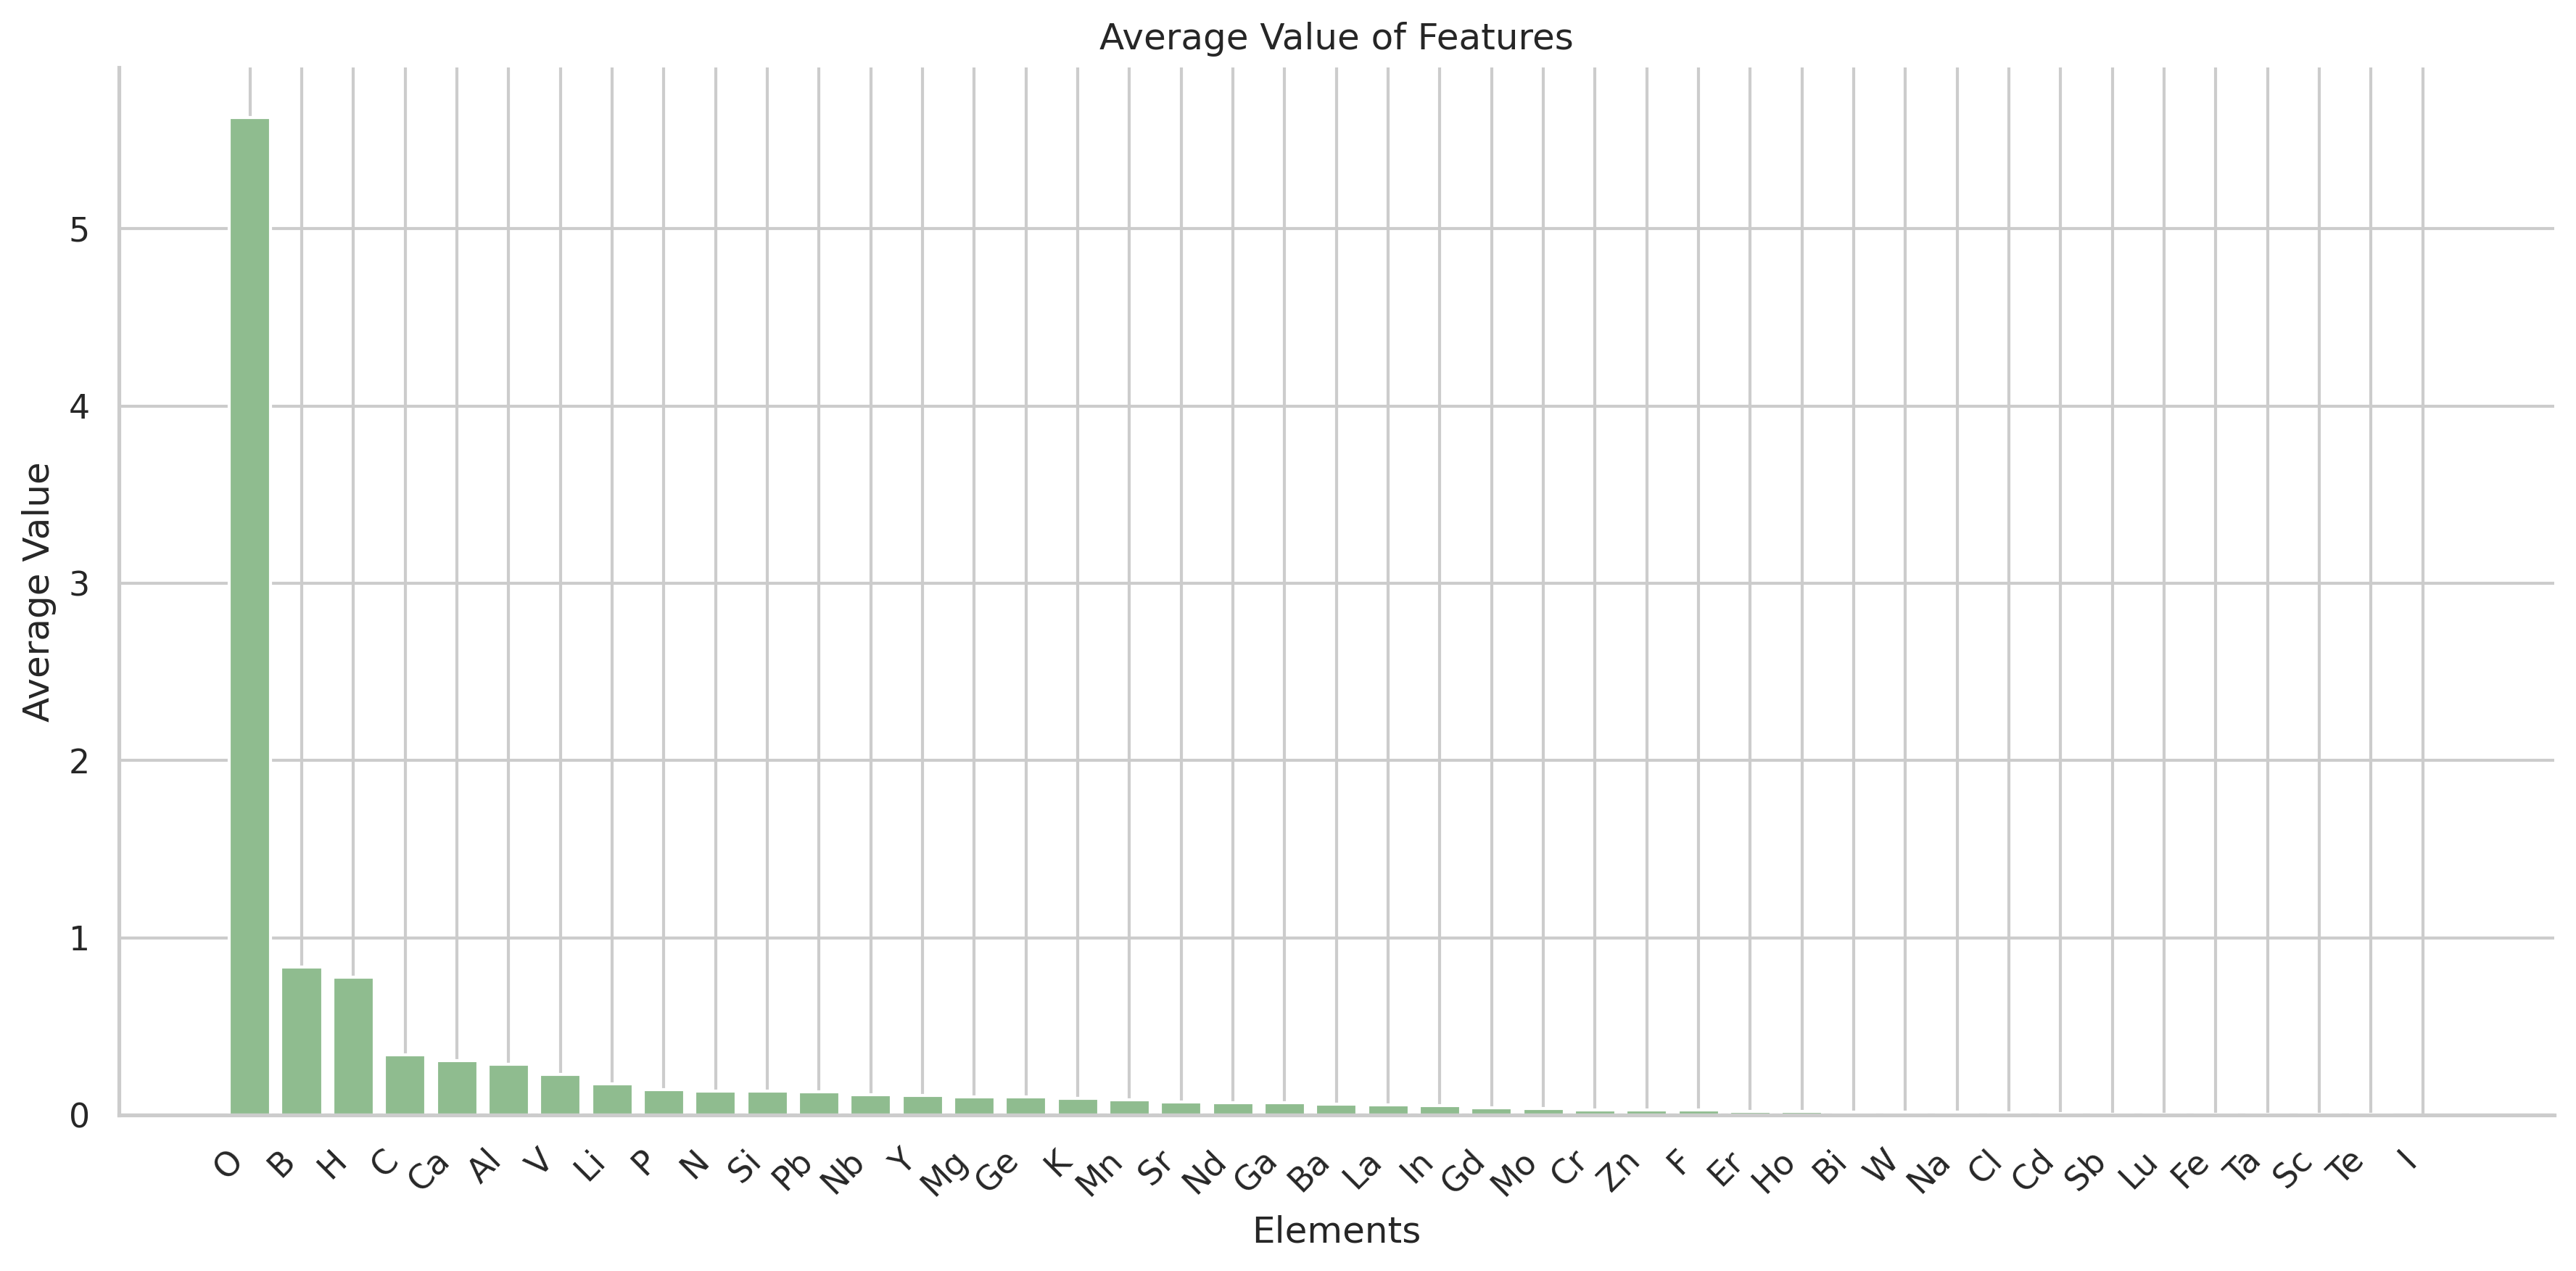

In [18]:
# Create a bargraph that shows how much each element is used on average
    # counts all instances of each element, then divides by number of rows

ele_feats = ['Al', 'B', 'Ba', 'Bi', 'C', 'Ca', 'Cd',
             'Cl', 'Cr', 'Er', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Ho', 'I', 'In',
             'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'O',
             'P', 'Pb', 'Sb', 'Sc', 'Si', 'Sr', 'Ta', 'Te', 'V', 'W', 'Y', 'Zn']

# Calculate sum for each feature and store results in a dictionary
feature_counts = {}
for feature in ele_feats:
    feature_sum = X[feature].sum()
    feature_count = feature_sum / X.shape[0]
    feature_counts[feature] = feature_count

# Sort the dictionary by values in descending order
sorted_feature_counts = dict(sorted(feature_counts.items(), key=lambda item: item[1], reverse=True))

# Set the font to Arial with DPI of 300
plt.rcParams["font.family"] = "Arial"
plt.rcParams["figure.dpi"] = 300

# Plotting the bar graph
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_counts.keys(), sorted_feature_counts.values(), color='darkseagreen')
plt.xlabel('Elements')
plt.ylabel('Average Value')
plt.title('Average Value of Features')
plt.xticks(rotation=45, ha='right')
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

💡 **insights:** 💡
- Almost every single compound has oxygen.
- The most popular elements are O, B, H, C, Ca, and Al.
- Strong right skew.

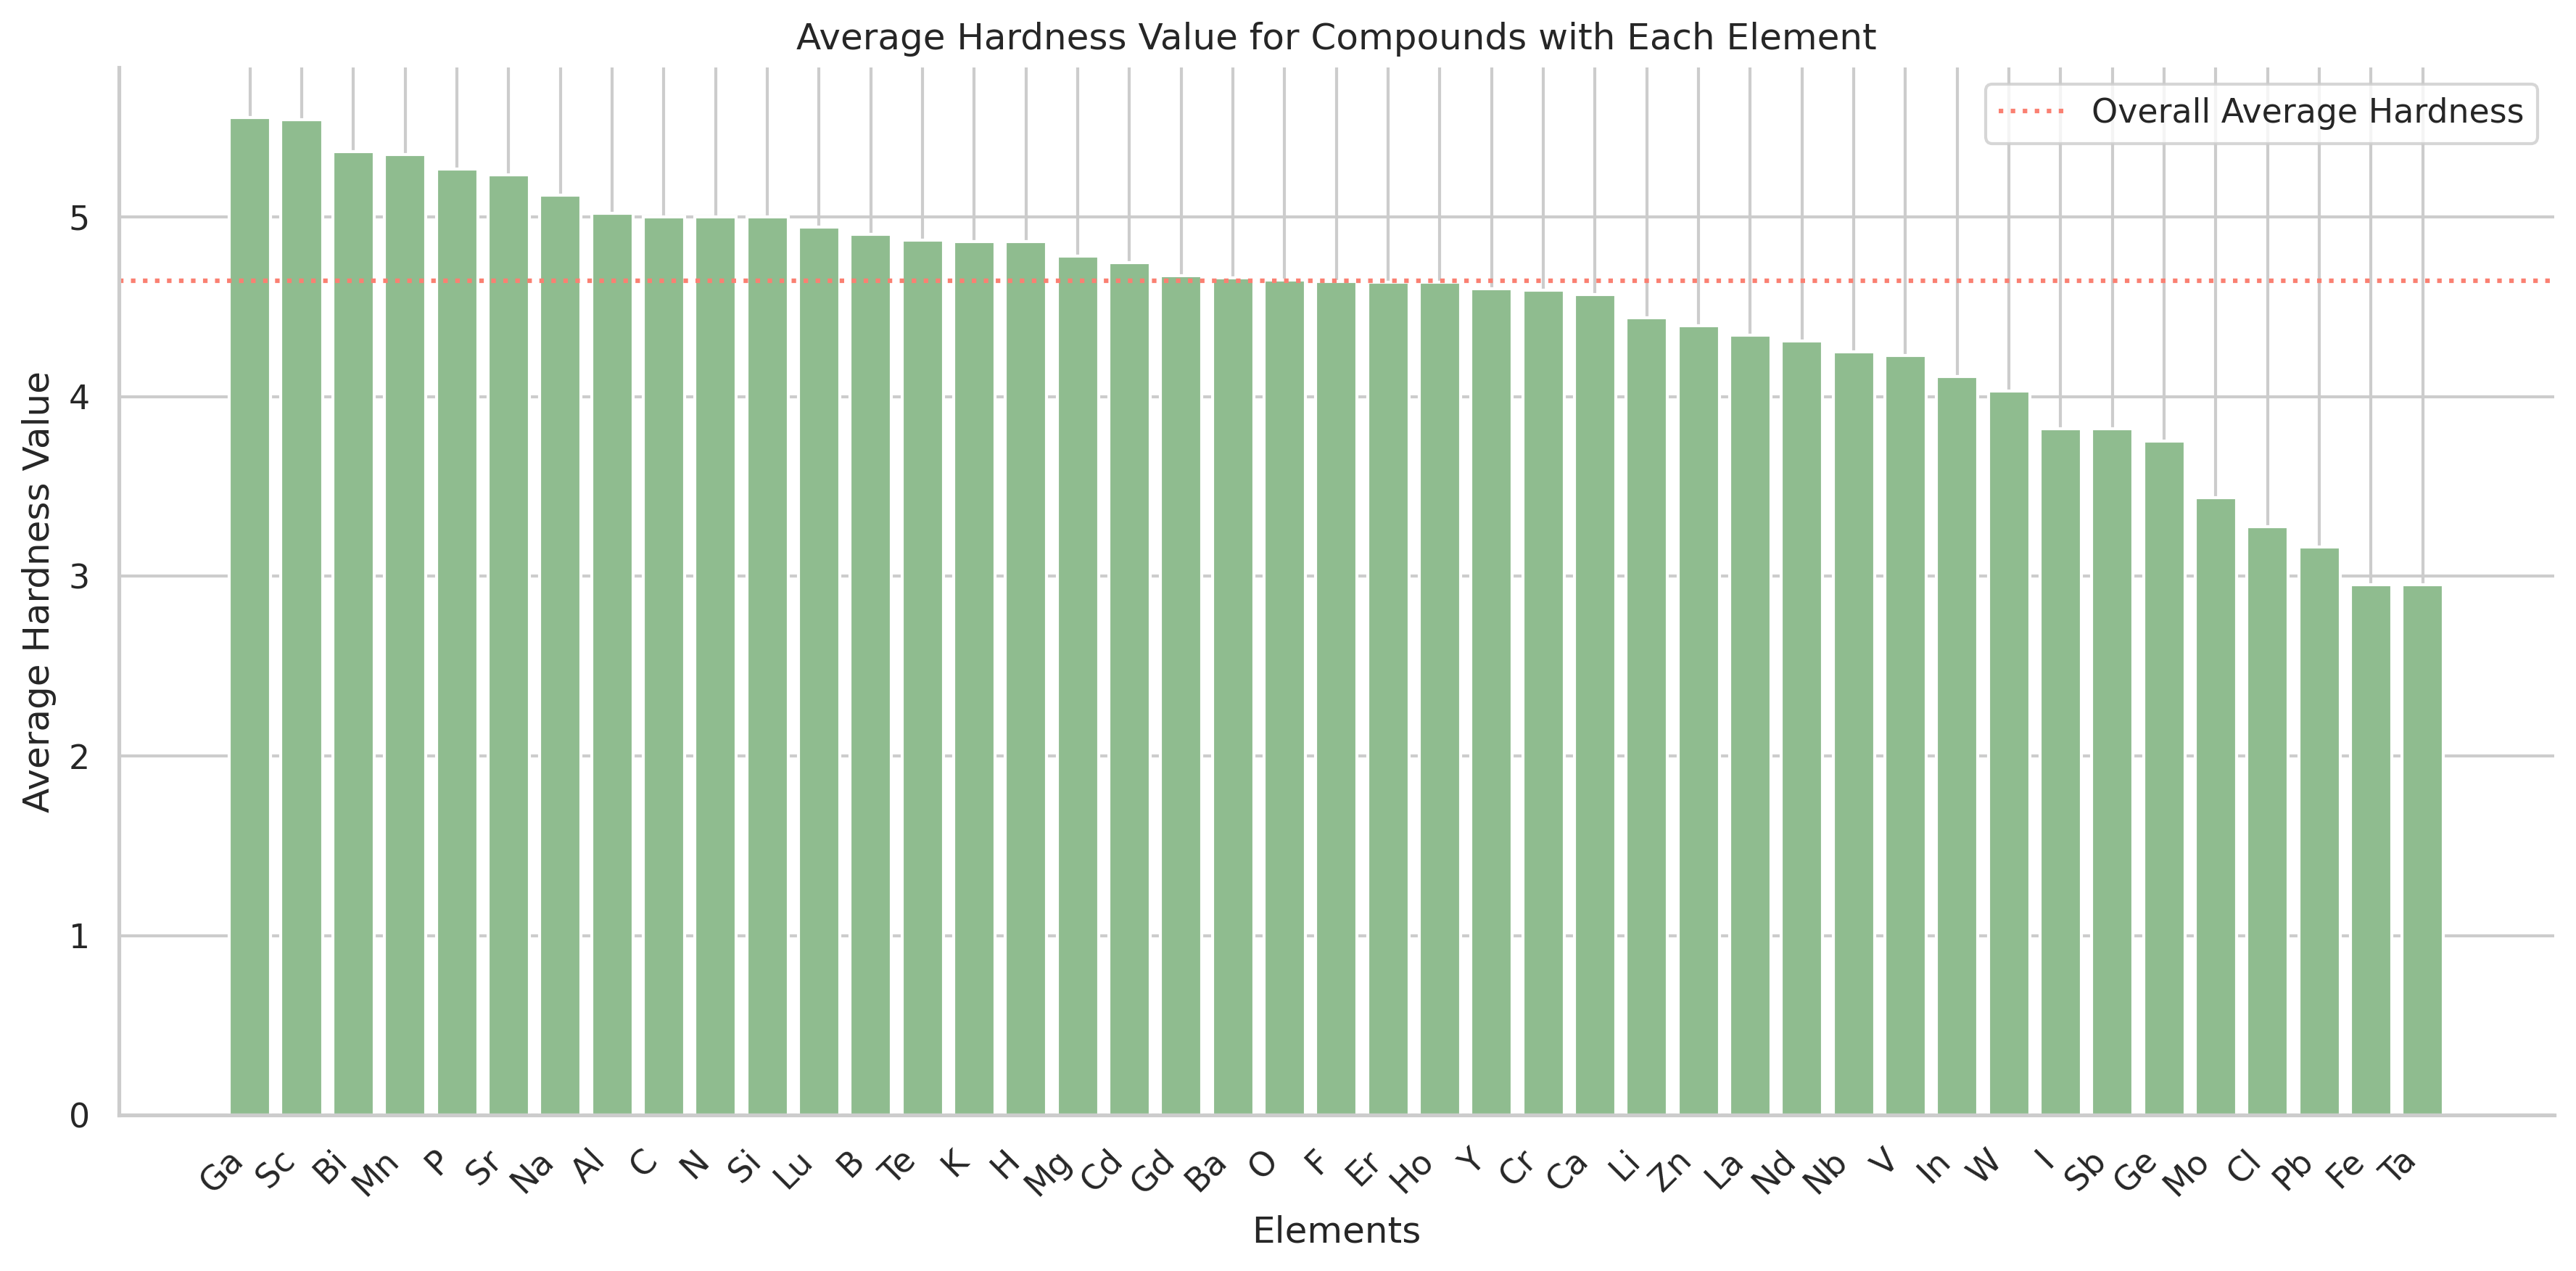

In [19]:
# Create bargraph that shows the the average hardness of each element based on whether or not it's present in the compound
    # So, doesn't matter how many instances of the element that's in the compound, just whether it's present or not (>0)

X_plus_y = pd.concat([X, y], axis=1)

average_hardness_values = {}
for ele in ele_feats:
    rows_with_element = X_plus_y[X_plus_y[ele] > 0]
    average_hardness_value = rows_with_element['Hardness'].mean()
    average_hardness_values[ele] = average_hardness_value

sorted_average_hardness_values = dict(sorted(average_hardness_values.items(), key=lambda item: item[1], reverse=True))

plt.rcParams["font.family"] = "Arial"
plt.rcParams["figure.dpi"] = 300

plt.figure(figsize=(12, 6))
plt.bar(sorted_average_hardness_values.keys(), sorted_average_hardness_values.values(), color='darkseagreen')
plt.xlabel('Elements')
plt.ylabel('Average Hardness Value')
plt.title('Average Hardness Value for Compounds with Each Element')
plt.xticks(rotation=45, ha='right')
sns.despine(top=True, right=True)

overall_average_hardness = X_plus_y['Hardness'].mean()
plt.axhline(y=overall_average_hardness, color='salmon', linestyle='dotted', label='Overall Average Hardness')

plt.legend()
plt.tight_layout()
plt.show()

💡 **insights:** 💡
- There does seem to be some serious variation in what each element brings to the table in terms of Hardness...

In [20]:
# Drop columns
def dropping_features(df):
    df = df.drop(['num_electrons', 
                  'formula_number', 'imputed_formula_decoded', 'Formula_new', 'element_dict', 
                  'unique_element_count', 'total_element_count', 'doped',
                  'Al', 'B', 'Ba', 'Bi', 'C', 'Ca', 'Cd',
                  'Cl', 'Cr', 'Er', 'F', 'Fe', 'Ga', 'Gd', 'Ge', 'H', 'Ho', 'I', 'In',
                  'K', 'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'O',
                  'P', 'Pb', 'Sb', 'Sc', 'Si', 'Sr', 'Ta', 'Te', 'V', 'W', 'Y', 'Zn'], axis=1)
    
    return df

X = dropping_features(X)
z = dropping_features(z)

💡 **insights:** 💡

Unfortunately, none of my genius features ended up improving my cross val, but hey, maybe you have better insight with how to implement them. My hunch is that A) formulas don't really have much influence over the compound hardness, B) my imputing routine isn't effective, or C) there were just too many unique forumlas in the original data, unlike the crystal structure. BUT my feature selection techniques aren't industry standard. I just experiment manually. If you have a robust feature selection algorithm, you may be able to utilize some of the features.

**Note:** interestingly, my CV did improve when I created these new features but then dropped them. My hunch is that maybe certain chemical formulas have certain crystal structure groups they fall into, which could help KMeans cluster. 

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Modeling</span>

In [21]:
base = 0.011
lower = 0.006
upper = 0.65

kfold = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

lgbm_params = {'n_estimators': 537, 'max_depth': 10, 'learning_rate': 0.08522253337076066, 
               'num_leaves': 47, 'min_data_in_leaf': 20, 'max_bin': 221, 
               'lambda_l1': 0.5013146365935452, 'lambda_l2': 0.7724702319440833,
               'min_gain_to_split': 0.24215691067519887}

LGBM = LGBMRegressor(objective='mae',
                     random_state=SEED,
                     verbose=-1,
                     n_jobs=-1,
                     **lgbm_params)

hgb_params = {'max_iter': 946, 'max_depth': 10, 'learning_rate': 0.05769927601402044, 
              'min_samples_leaf': 36, 'max_leaf_nodes': 61, 
              'l2_regularization': 0.4600658510642346, 'max_bins': 71}

HGB = HistGradientBoostingRegressor(random_state=SEED, 
                                    loss='absolute_error',
                                    **hgb_params)

voting_regressor = VotingRegressor(estimators = [('LGBM', LGBM),('HGB', HGB)],
                               n_jobs = -1, 
                               weights = [1, 1.3])

voter = voting_regressor.fit(X, y)

y_AE = np.abs(y - voting_regressor.predict(X))
sample_weight_train = base + ((lower < y_AE) & (y_AE < upper))

voter = voting_regressor.fit(X, y, sample_weight=sample_weight_train)
medae = median_absolute_error(y, voting_regressor.predict(X))

voting_preds = voter.predict(z)

[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724702319440833, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7724702319440833
[LightGBM] [Warning] lambda_l1 is set=0.5013146365935452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5013146365935452
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_gain_to_split is set=0.24215691067519887, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.24215691067519887
[LightGBM] [Warning] lambda_l2 is set=0.7724

💡 **insights:** 💡

Why'd I chose these models? Simple. They improved my CV the most. I tried XGB and CAT, but using their predictions, **even** with a negligible weight, really hurt my model. I tried using the weight creation technique that Oscar suggested and used in previous competitions, it didn't help my CV over what I already had. 
- Either, I've chosen the best models for my configuration, or I'm overfitting. The private leaderboard will tell all. I'm probably overfitting.

# <span style="font=family:Arial; font-weight:bold; color:green; font-size:150%;">Submission form</span>

In [22]:
sample['Hardness'] = voting_preds
print(sample.head(3))
sample.to_csv("submission.csv", index = False)
print()
print("File submitted...")
print("You've earned yourself a coffee...")

      id  Hardness
0  10407  2.482978
1  10408  2.472366
2  10409  5.978886

File submitted...
You've earned yourself a coffee...


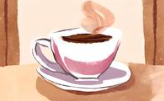